In [2]:
%matplotlib inline

import numpy as np # NUMPY
import pandas as pd # PANDAS
import matplotlib.pyplot as plt # MATPLOTLIB
import seaborn as sns # SEABORN
import scipy
import sklearn
from sklearn.decomposition import PCA
import cv2
import os 
from skimage import filters
from scipy import ndimage

In [5]:
cant_frames_per_seq = pd.read_csv('cktraining_landmark_FramePerSeq.csv',header = None)
cant_frames_per_seq = np.asarray(cant_frames_per_seq).flatten()

subject_images = []
warpimgpath = '../ck+warpedtraining'
for i in range(0, len(os.listdir(warpimgpath))):
    subject_images.append('../ck+warpedtraining/' + 'warped_image_procustres_' + str(i)+'.png')
subject_images = np.asarray(subject_images)

my_df = pd.DataFrame(subject_images)
my_df.to_csv('cktraining_subject_images.csv',header = False, index= False)



In [5]:
from skimage import filters

def ComputeImageGradient(image, way):
    if way == 0:
        GradX = cv2.Sobel(image, ddepth=-1, dx=1, dy=0, borderType=cv2.BORDER_REFLECT)
        GradY = cv2.Sobel(image, ddepth=-1, dx=0, dy=1, borderType=cv2.BORDER_REFLECT)
        GradX[-1,:] = 0
        GradY[:, -1] = 0 # Neumann boundary Condition
    elif way == 1:
        GradX, GradY = np.gradient(image)      
        GradX[-1,:] = 0
        GradY[:, -1] = 0 # Neumann boundary Condition     
    elif way == 2: 
        Kx = -1*np.array([[-1,0,1]])
        GradX = ndimage.convolve(img, Kx)
        Ky = -1*np.array([[-1],[0],[1]])
        GradY = ndimage.convolve(img, Ky)
        GradX[-1,:] = 0
        GradY[:, -1] = 0 # Neumann boundary Condition  
    else:
        print('not legal way')
        GradY = np.zeros(image.shape)
        GradX = np.zeros(image.shape)
    return GradX, GradY


#ComputeImageGradient(img,  0)
#gradx



In [6]:
from numpy import linalg as LA
def ProximalF_Star(img_p1,img_p2):
    inp1 = img_p1.flatten()    
    inp2 = img_p2.flatten()# (313600,1)
    p_total =  np.dstack((inp1, inp2)) # queda (1,313600,2)
    p_total = p_total[0]

    partial = np.zeros(len(p_total))
    
    partial = np.asarray(list(map(LA.norm, p_total))) # cada el de p_total la norma 2
    partial = np.asarray(list(map(lambda e: max(1.0,e), partial)))
    
    partial = partial.reshape(img_p1.shape)
    
    output_img_p1 = img_p1 / partial
    output_img_p2 = img_p1 / partial 


    return output_img_p1, output_img_p2


In [5]:
LA.norm([1,3], ord = 2)

3.1622776601683795

In [6]:
(1**2+3**2)**(1/2)

3.1622776601683795

In [7]:
def ComputeDivergenceL(img_p1, img_p2, way=1, sp=[1,1]):
    if way == 0 :
        p1_dx =  cv2.Sobel(img_p1, ddepth=-1, dx=1, dy=0, borderType=cv2.BORDER_REFLECT)
        p2_dy =  cv2.Sobel(img_p2, ddepth=-1, dx=0, dy=1, borderType=cv2.BORDER_REFLECT)
        output_image = p1_dx + p2_dy
    elif way == 1 :
        width, height =img_p1.shape
        inp1 = img_p1.flatten()
        inp2 = img_p2.flatten()#no se si f o c
        vector_field = np.array([inp1, inp2])
        num_dims = 2        
        output_image = np.ufunc.reduce(np.add, [np.gradient(vector_field[i], sp[i], axis =0) for i in range(num_dims)]) 
        output_image = output_image.reshape(width,height)        
    return output_image

In [8]:
def ProximalG(img_u, img_g, landa, tau):
    resta = img_u - img_g    
    output_image = np.zeros(img_u.shape)
    
    maskH = resta > landa*tau
    maskL = resta < -1*(landa*tau)
    maskB = np.abs(resta) <= landa*tau 

    lander = np.zeros(img_u.shape)
    lander.fill(landa*tau)
    
    landerA = lander *maskH
    imageA = img_u * maskH
    landerB = lander * maskL
    imageB = img_u * maskL    
   
    
    imageA = imageA - landerA
    imageB = imageB + landerB
    imageC = img_g * maskB
    
    output_image  = imageA +imageB + imageC    

    return output_image

In [9]:
landa = 0.5
tau = 0.5
img_g = np.asarray([[3,3,3],[3,3,3],[3,3,3]])
resta = np.asarray([[1,-1,0.10],[0.5,0.15,-2],[0.09,-1,-6]])
img_u = np.zeros((3,3))
j =ProximalG(img_u, img_g, landa, tau, resta)
g =ProximalGD(img_u, img_g, landa, tau, resta)
j,g

TypeError: ProximalG() takes 4 positional arguments but 5 were given

In [9]:
def ProximalGD(img_u, img_g, landa, tau, resta):
    #resta = img_u - img_g    
    output_image = np.zeros(img_u.shape)
    for i in range(0, len(img_u)):
        for j in range(0, len(img_u[i])):            
            if resta[i][j] > landa*tau :
                output_image[i][j] = img_u[i][j] - (landa*tau)
            elif resta[i][j] < -1*(landa*tau):
                output_image[i][j] = img_u[i][j] + (landa*tau)
            else: # si el modulo de la resta es menor a landa*tau
                output_image[i][j] = img_g[i][j]
    return output_image

In [10]:
def ProximalGL(img_u, img_g, landa, tau):
    resta = img_u - img_g    
    output_image = np.zeros(img_u.shape)
    for i in range(0, len(img_u)):
        for j in range(0, len(img_u[i])):            
            if resta[i][j] > landa*tau :
                output_image[i][j] = img_u[i][j] - (landa*tau)
            elif resta[i][j] < -1*(landa*tau):
                output_image[i][j] = img_u[i][j] + (landa*tau)
            else: # si el modulo de la resta es menor a landa*tau
                output_image[i][j] = img_g[i][j]
    return output_image

Vamos ahora si a tratar de hacer la decomposition con el paper

In [11]:
def Chambolle_TV_L1(input_image, nb_iter, tau, sigma, landa, tetha, way):
    # inicializacion
    width, height  = input_image.shape
    size_image = width * height
    
    u = input_image    
    u_old = np.zeros(input_image.shape)    
    p1 =  np.zeros(input_image.shape)# p = (p1, p2) o (px, py)
    p2= np.zeros(input_image.shape)
    img1 = np.zeros(input_image.shape)
    img2 = np.zeros(input_image.shape)
    GradX = np.zeros(input_image.shape)
    GradY = np.zeros(input_image.shape)
    
    E = float('inf')
    
        
    for it in range (1, nb_iter):
        u_old = u
        GradX, GradY = ComputeImageGradient(u, way) 
        im1 = p1+ sigma*GradX
        im2 = p2 + sigma*GradY
        p1, p2 = ProximalF_Star(im1,im2)        
        div = ComputeDivergenceL(p1, p2)        
        image1 = u + tau*div
        u = ProximalG(image1, input_image, landa, tau)
        u = u + tetha* (u - u_old)
        
        if( it % 10 == 0):
            E_old = E
            E = 0
            GradX, GradY = ComputeImageGradient(u, way)
            E += np.sum(landa * abs(u-input_image) + np.sqrt(GradX**2 + GradY**2))
            E = E/size_image
            if(abs(E-E_old) < 0.001): break
    
    return u


In [12]:
def cartoonTexture_grey(input_image, landa, nb_iter_max=1000, tau=0.35, sigma=0.35, tetha =1.0, way =3):
    
    
    cartoon = np.zeros(input_image.shape)    
    cartoon = Chambolle_TV_L1(input_image, nb_iter_max, tau, sigma, landa, tetha, way)
    
    GradX = np.zeros(input_image.shape) 
    GradY = np.zeros(input_image.shape) 
    
    BV_norm = 0.0
    
    GradX, GradY = ComputeImageGradient(cartoon, way)
    
    BV_norm += np.sum((GradX **2 + GradY **2)**(1/2))     
    
    
    vLim = 20.0
    
    texture = np.zeros(input_image.shape)
    
    texture = input_image - cartoon
    
    texture  = (texture + vLim )*255.0 /(2.0* vLim)
    maskL = texture  >= 0.0 # para que quede 0 cuando es menor a 0
    texture = texture * maskL
    texture[texture >255.0] =255.0 
      
    return cartoon, texture
    


Ahora tenemos los algoritmos vamos a

1) conseguir los cartoon textura para todas las imagenes
2) guardarlas en una database

 

In [13]:
cant_frames_per_seq = pd.read_csv('cktraining_landmark_FramePerSeq.csv',header = None)
cant_frames_per_seq = np.asarray(cant_frames_per_seq).flatten()

subject_images = []
warpimgpath = '../ck+warpedtraining'
for i in range(0, len(os.listdir(warpimgpath))):
    subject_images.append('../ck+warpedtraining/' + 'warped_image_procustres_' + str(i)+'.png')
subject_images = np.asarray(subject_images)

img = cv2.imread(subject_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
width, height = img.shape
width, height

(490, 640)

In [14]:
subject_images = []
warpimgpath = '../ck+warpedtraining'
for i in range(0, len(os.listdir(warpimgpath))):
    subject_images.append('../ck+warpedtraining/' + 'warped_image_procustres_' + str(i)+'.png')
subject_images = np.asarray(subject_images)

img = cv2.imread(subject_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img[40:450, 170:580]
cv2.imshow("Texture start", img)
# Pause screen to wait key from user to see result
cv2.waitKey(0)
cv2.destroyAllWindows()


In [20]:
img = cv2.imread(subject_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2 = img[40:450, 170:580]
print(img2.shape)
cartoon, texture = cartoonTexture_grey(img2, 0.2, 50, 0.35, 0.35, 1.0, 0)
cv2.imwrite("cartoon_training/cartoonimg" + str(i) +"lala"+".png", cartoon)
cv2.imwrite("texture_training/textureimg" + str(i)+"lala"+".png", texture)

(410, 410)


True

In [15]:
for i in range (689,  len(subject_images)):#last time we stopped last finished  in 688
    img = cv2.imread(subject_images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = img[40:450, 170:580]
    print(img2.shape)
    cartoon, texture = cartoonTexture_grey(img2, 0.2, 50, 0.35, 0.35, 1.0, 0)
    cv2.imwrite("cartoon_training/cartoonimg" + str(i) +".png", cartoon)
    cv2.imwrite("texture_training/textureimg" + str(i)+".png", texture)

(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)

KeyboardInterrupt: 

In [2]:

cartoon_images = []
warpimgpath = 'cartoon_training/'
for i in range(0, len(os.listdir(warpimgpath))):
    cartoon_images.append('cartoon_training/' + 'cartoonimg' + str(i)+'.png')
cartoon_images = np.asarray(cartoon_images)

In [3]:
cartoon_images[0]

'cartoon_training/cartoonimg0.png'

In [6]:
counter = 0
state = 0
frame_counter = 0
subject_first = np.zeros(len(subject_images))
for i in range(0, len(subject_images)):
    subject_first[i] = state 
    counter = counter + 1
    if counter == cant_frames_per_seq[frame_counter]: 
        counter = 0
        state +=  cant_frames_per_seq[frame_counter]
        frame_counter += 1
        


In [9]:
subject_first.shape

48.0

In [10]:
imcart = []
for i in cartoon_images:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img_mean = img/np.mean(img)
    imcart.append(img_mean.flatten())
    
imcartoon = np.asarray(imcart)
imcartooncopy = []
for i in range(0, len(imcartoon) ):
    first_frame = int(subject_first[i])
    imca = imcartoon[i] - imcartoon[first_frame]
    imcartooncopy.append(np.asarray(imca))

imcartoonarray = np.asarray(imcartooncopy)
imcartoonarray.shape

#my_df = pd.DataFrame(imcartoonarray)
#my_df.to_csv('im_training_cartoonarray.csv',header = False, index= False)


(1107, 168100)

In [12]:
np.savetxt('im_training_cartoonarray_longer.csv', imcartoonarray, delimiter=",")


In [20]:
texture_images = []
warpimgpath = 'texture_training/'
for i in range(0, len(os.listdir(warpimgpath))):
    texture_images.append('texture_training/' + 'textureimg' + str(i)+'.png')
texture_images = np.asarray(texture_images)

In [21]:
imtext = []
for i in texture_images:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)    
    imtext.append(img.flatten())
    
imtextarray = np.asarray(imtext)
imtextarray.shape

#my_df = pd.DataFrame(imtextarray)
#my_df.to_csv('im_training_texturearray.csv',header = False, index= False)

In [ ]:
np.savetxt('im_training_texturearray_longer.csv', imcartoonarray, delimiter=",")

Los archivos pueden ser demasiado grandes, por lo que los leemos en chunks


In [3]:
file_path = 'im_training_cartoonarray_longer.csv'
chunk_size = 200

df_list = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size, header = None):
    df_list.append(chunk)

df = pd.concat(df_list)

In [3]:
df

<bound method NDFrame.head of         0         1         2         3         4         5         6       \
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    -0.005133 -0.005133 -0.005133 -0.005133 -0.005133 -0.005133 -0.005133   
2     0.003569  0.003569  0.003569  0.003569  0.003569  0.003569  0.003569   
3    -0.007812 -0.007812 -0.007812 -0.007812 -0.007812 -0.007812 -0.007812   
4     0.003143  0.003143  0.003143  0.003143  0.003143  0.003143  0.003143   
...        ...       ...       ...       ...       ...       ...       ...   
1102  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1103 -0.009309  0.000123 -0.009309 -0.009309 -0.009309 -0.009309  0.000125   
1104 -0.000403  0.009028 -0.000403 -0.000403 -0.000403  0.009024  0.009024   
1105  0.009353  0.009354  0.009353 -0.000078  0.009353 -0.000078  0.009353   
1106  0.002886  0.012317  0.002886  0.002886  0.002886  0.002886  0.012351   

        7         8         9    

In [4]:
my_data_forPCA = df

In [ ]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_forPCA)
scaled_landDiff.shape

In [5]:
my_data_forPCA = []

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)#era 14
pca.fit_transform(scaled_landDiff)
b_cartoon = pca.fit_transform(scaled_landDiff)
b_cartoon.shape # 

In [6]:
print(sum(pca.explained_variance_ratio_))

0.2210463534135603


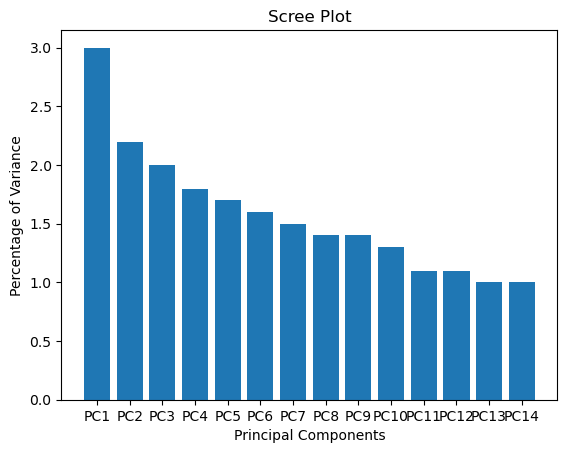

In [7]:
b_cartoon
pca_var=np.round(pca.explained_variance_ratio_* 100, decimals=1 )
labels = ['PC'+ str(s) for s in range(1, len(pca_var)+1)]

plt.bar(x= range(1, len(pca_var)+1), height = pca_var, tick_label= labels)
plt.ylabel("Percentage of Variance")
plt.xlabel("Principal Components")
plt.title("Scree Plot")
plt.savefig("CartoonPCALongerData.png") 
plt.show()

In [8]:
my_df = pd.DataFrame(b_cartoon)
my_df.to_csv('pca_cartoontrainingpoints_longer.csv',header = False, index= False)

In [11]:
file_path = 'im_training_texturearray_longer.csv'
chunk_size = 200

df_list = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size, header = None):
    df_list.append(chunk)

df2 = pd.concat(df_list)

In [12]:
my_data_forPCA2 =df2

In [13]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_forPCA2)
scaled_landDiff.shape

(689, 168100)

In [ ]:
my_data_forPCA = []

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)#era 14
pca.fit_transform(scaled_landDiff)
b_texture = pca.fit_transform(scaled_landDiff)
b_texture.shape # 

(689, 14)

In [15]:
print(sum(pca.explained_variance_ratio_))

0.6525849877633989


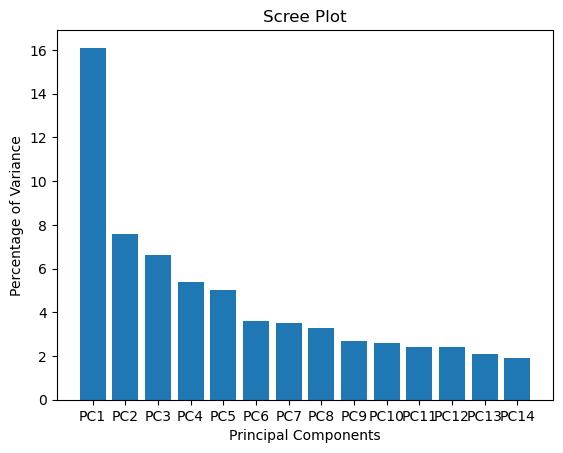

In [16]:
b_texture
pca_var=np.round(pca.explained_variance_ratio_* 100, decimals=1 )
labels = ['PC'+ str(s) for s in range(1, len(pca_var)+1)]

plt.bar(x= range(1, len(pca_var)+1), height = pca_var, tick_label= labels)
plt.ylabel("Percentage of Variance")
plt.xlabel("Principal Components")
plt.title("Scree Plot")
plt.savefig("TexturePCALongerData.png") 
plt.show()

In [15]:
my_df = pd.DataFrame(b_texture)
my_df.to_csv('pca_texturetrainingpoints_longer.csv',header = False, index= False)

In [22]:
cartoon, texture = cartoonTexture_grey(img, 0.7, 50, 0.35, 0.35, 1.0, 0)

cartoon, img, texture

NameError: name 'ProximalG' is not defined

In [23]:
Hori = np.concatenate((cartoon, texture), axis=1) 
cv2.imshow('Cartoon Texture', Hori) 
cv2.waitKey(0) 
cv2.destroyAllWindows()  

cv2.imwrite("ejemplotexcartoondescom07w0.png", Hori)

True

In [ ]:
To counter this dependence, for each face image we di-
vide each element of the u component by the mean value of
u of that ima

In [45]:
result = (cartoon_vector == a).all()
result

True